In [1]:
# import packages
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
from helper import *
import ipywidgets as widgets

# variables
time_period = (1, 2, 3, 4, 5) # 5 different implementation of progression order  
n_patients = 0 # number of patients included in the model  
n_sessions = 0 # number of sessions included in the model  
usage_time: how many months the patient has been using the app  
usage_freq: how frequent the patient uses the app  

Clean Data

In [2]:
# querying from the SQL database, 2 mins for q3 table

from connection import *

con = connect()
df = SQL("queries/model_query.sql", con)
# df = df.rename(columns={'session_id':"id"})

Connection Successful


In [3]:
# 1 min, data saved from previous runs
# df = pd.read_csv("data/model_data.csv")
df.head()

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
0,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
1,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
2,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
3,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
4,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"


In [4]:
df.nunique()

id               7008614
patient_id         68780
start_time       6693130
task_type_id         173
task_level            12
domain_ids            27
domain_scores     191137
dtype: int64

In [5]:
# 20 seconds
# deficit_ids = df.groupby("patient_id")["deficit_id"].apply(set).reset_index()
# df = df.drop(columns="deficit_id")
# df = df.merge(deficit_ids, on="patient_id", how="left")

In [6]:
# 1 min
# domain_ids = df.groupby("id")["domain_id"].apply(set).reset_index()
# df = df.drop(columns="domain_id")
# df = df.merge(domain_ids, on="id", how="left")

In [7]:
df = df.drop_duplicates(subset="id")

In [8]:
df.head()

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
0,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
5,11042076,2171,2018-04-15 23:48:00,4,1,"6,10","0.3050,0.8000"
10,11057448,2171,2018-04-16 21:55:03,4,1,"6,10","0.3160,0.7930"
15,11069816,2171,2018-04-17 17:54:54,4,1,"6,10","0.3160,0.8070"
20,11742188,2171,2018-06-05 17:35:50,4,1,"6,10","0.2740,0.8360"


In [9]:
df.nunique()

id               7008614
patient_id         68780
start_time       6693130
task_type_id         173
task_level            12
domain_ids            27
domain_scores     191137
dtype: int64

In [10]:
# df.to_csv("data/consolidate_data_w_ds.csv", index=False)
## careful when reading, will read set as string
# df = pd.read_csv("data/consolidate_data.csv", index_col=[0])
df

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
0,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
5,11042076,2171,2018-04-15 23:48:00,4,1,"6,10","0.3050,0.8000"
10,11057448,2171,2018-04-16 21:55:03,4,1,"6,10","0.3160,0.7930"
15,11069816,2171,2018-04-17 17:54:54,4,1,"6,10","0.3160,0.8070"
20,11742188,2171,2018-06-05 17:35:50,4,1,"6,10","0.2740,0.8360"
...,...,...,...,...,...,...,...
80506826,41286101,584095,2023-05-22 17:29:53,255,3,12,0.6790
80506830,41465313,584095,2023-05-25 19:56:38,255,3,12,0.6670
80506834,41530297,584095,2023-05-30 03:44:54,255,3,12,0.6670
80506838,41585933,584095,2023-05-31 00:33:20,255,3,12,0.6550


All data has been consolidated, there should be no duplicate sessions for different disorders/domains.
We want to add time_period, usage_time, and usage_freq to the dataset.

**This part doesn't need to be run if it's claire's data**

In [11]:
# progression_order_df = pd.read_csv("data/progression_order.csv", index_col=[0])
# progression_order_df.rename(columns={'time_implemented':'start_time'}, inplace=True)
# progression_order_df["start_time"] = pd.to_datetime(progression_order_df["start_time"])
# df["start_time"] = pd.to_datetime(df["start_time"])

In [12]:
# def time_period_convert(dd):
#     dates = sorted(pd.unique(progression_order_df["start_time"]))
#     if dd < pd.to_datetime(dates[1]):
#         return 1
#     elif dd < pd.to_datetime(dates[2]):
#         return 2
#     elif dd < pd.to_datetime(dates[3]):
#         return 3
#     elif dd < pd.to_datetime(dates[4]):
#         return 4
#     else:
#         return 5

In [13]:
# added time period, takes around 8-9 minutes to run
# df["time_period"] = df["start_time"].apply(time_period_convert)
# df

In [14]:
# progression_order_df["time_period"] = progression_order_df["start_time"].apply(time_period_convert)
# progression_order_df

Adding Usage Time
* this is by patient
* need a patient dataframe vs session dataframe (df)

In [15]:
df["start_time"] = pd.to_datetime(df["start_time"])
df = df.sort_values(by="start_time")

In [16]:
df

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
5511562,2361763,45118,2015-09-15 00:33:12,37,1,"1,10,11","0.3570,0.1430,0.8000"
7380488,3553755,62917,2016-04-26 21:21:08,77,1,8,0.0280
11225782,6334548,97021,2017-03-13 00:49:21,79,3,9,0.6000
17344069,8391327,134153,2017-09-21 17:46:51,37,1,"1,10,11","0.3430,0.3640,0.7600"
17245321,8412262,133639,2017-09-23 14:59:22,20,2,1,0.3570
...,...,...,...,...,...,...,...
4080248,41974214,35004,2023-06-22 03:09:03,235,6,14,0.8670
6783830,41976112,54405,2023-06-22 03:15:19,136,6,13,0.5410
6760870,41976113,54405,2023-06-22 03:16:52,13,2,2,0.3800
6765630,41976114,54405,2023-06-22 03:20:17,26,2,5,0.2580


In [17]:
patients = (df.groupby("patient_id")["start_time"].max() - df.groupby("patient_id")["start_time"].min()).reset_index()
patients.columns = ["patient_id", "usage_time"]
patients["usage_time"] = patients["usage_time"].dt.days + 1
patients

,patient_id,usage_time
0,2171,1500
1,2281,1967
2,2466,894
3,2517,1140
4,3882,1
...,...,...
68775,560491,49
68776,565981,57
68777,568669,268
68778,575513,67


Add usage_freq for patient dataframe
* using the simplest way of calculating frequency
* how to get rid of outlier

In [18]:
patients["session_count"] = df.groupby("patient_id")["id"].count().reset_index(name="session_count")["session_count"]
patients["unique_days"] = df.groupby("patient_id")["start_time"].nunique().reset_index(name="days")["days"]
patients

,patient_id,usage_time,session_count,unique_days
0,2171,1500,3221,3221
1,2281,1967,618,618
2,2466,894,12,12
3,2517,1140,1521,1521
4,3882,1,2,2
...,...,...,...,...
68775,560491,49,60,60
68776,565981,57,1105,1105
68777,568669,268,1103,1103
68778,575513,67,118,118


In [19]:
patients["usage_freq"] = patients["unique_days"] / patients["usage_time"]
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,2171,1500,3221,3221,2.147333
1,2281,1967,618,618,0.314184
2,2466,894,12,12,0.013423
3,2517,1140,1521,1521,1.334211
4,3882,1,2,2,2.000000
...,...,...,...,...,...
68775,560491,49,60,60,1.224490
68776,565981,57,1105,1105,19.385965
68777,568669,268,1103,1103,4.115672
68778,575513,67,118,118,1.761194


## create training data before outliers are filtered

How to remove outlier

In [20]:
from sklearn.cluster import DBSCAN

def filter_datetime_outliers(data, column="start_time", eps_days=7, min_samples=10):
    """
    Filters outlier dates by clustering unique days with DBSCAN.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing datetime column.
    - column (str): Name of the datetime column.
    - eps_days (int): Max days apart for dates to be considered in the same cluster.
    - min_samples (int): Minimum number of unique days required to form a cluster.
    
    Returns:
    - pd.DataFrame: Filtered DataFrame containing only clustered dates.
    """
    df = data.copy()

    # Convert dates to numerical timestamps
    df["timestamp"] = df[column].astype(np.int64) // 10**9  # Convert to seconds

    # Apply DBSCAN clustering
    eps_seconds = eps_days * 24 * 60 * 60  # Convert days to seconds
    clustering = DBSCAN(eps=eps_seconds, min_samples=min_samples).fit(df[["timestamp"]])
    
    # Assign cluster labels
    df["cluster"] = clustering.labels_

    # Remove outliers (DBSCAN labels outliers as -1)
    filtered_df = df[df["cluster"] != -1].drop(columns=["timestamp", "cluster"])

    return filtered_df


In [21]:
# modified from https://stackoverflow.com/questions/56750841/how-to-trim-outliers-in-dates-in-python
def datetime_outlier(data):
    qa = data["start_time"].quantile(0.2) #lower 10%
    qb = data["start_time"] #higher 10%
    #remove outliers
    xf = data[(data.start_time >= qa) & (data.start_time <= qb)]
    return xf

In [22]:
# about a min
patients_v2 = df.groupby("patient_id")[df.columns].apply(filter_datetime_outliers).reset_index(drop=True)

In [23]:
df[df.patient_id == 584095].sort_values(by="start_time")

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
80506550,38748396,584095,2022-12-07 01:33:52,134,1,3,0.0370
80506678,38748397,584095,2022-12-07 01:36:22,212,6,5,0.0000
80506554,38840767,584095,2022-12-13 02:41:39,134,1,3,0.0370
80506682,38840768,584095,2022-12-13 02:47:04,212,6,5,0.4200
80506422,38840769,584095,2023-01-06 22:15:03,13,5,2,0.0000
...,...,...,...,...,...,...,...
80506642,41858185,584095,2023-06-17 20:29:23,207,5,12,0.5330
80506478,41858186,584095,2023-06-17 20:46:31,26,4,5,0.5350
80506498,41858187,584095,2023-06-17 20:52:27,26,5,5,0.5350
80506626,41858188,584095,2023-06-21 00:26:53,167,1,"4,5","0.8750,0.5550"


In [24]:
patients_v2[patients_v2.patient_id == 584095].sort_values(by="start_time")

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
6608399,40946268,584095,2023-04-20 00:22:17,212,10,5,0.3350
6608400,40946269,584095,2023-04-20 00:41:38,13,5,2,0.3170
6608401,40946270,584095,2023-04-20 00:46:13,254,3,5,0.3350
6608402,41058178,584095,2023-04-26 23:26:56,215,1,"3,13","0.0810,0.0810"
6608403,41058179,584095,2023-04-26 23:29:14,215,7,"3,13","0.1850,0.2710"
...,...,...,...,...,...,...,...
6608490,41858185,584095,2023-06-17 20:29:23,207,5,12,0.5330
6608491,41858186,584095,2023-06-17 20:46:31,26,4,5,0.5350
6608492,41858187,584095,2023-06-17 20:52:27,26,5,5,0.5350
6608493,41858188,584095,2023-06-21 00:26:53,167,1,"4,5","0.8750,0.5550"


In [25]:
patients_v2.nunique()

id               6608495
patient_id         29459
start_time       6327908
task_type_id         173
task_level            12
domain_ids            27
domain_scores     186958
dtype: int64

In [26]:
patients_filtered = (patients_v2.groupby("patient_id")["start_time"].max() - patients_v2.groupby("patient_id")["start_time"].min()).reset_index()
patients_filtered.columns = ["patient_id", "usage_time"]
patients_filtered["usage_time"] = patients_filtered["usage_time"].dt.days + 1
patients_filtered

,patient_id,usage_time
0,2171,1442
1,2281,1944
2,2517,699
3,4032,534
4,4073,10
...,...,...
29454,560491,41
29455,565981,57
29456,568669,268
29457,575513,46


In [27]:
patients_filtered["session_count"] = patients_v2.groupby("patient_id").size().reset_index(name="session_count")["session_count"]
patients_filtered["unique_days"] = patients_v2.groupby("patient_id")["start_time"].nunique().reset_index(name="days")["days"]
patients_filtered["usage_freq"] = patients_filtered["unique_days"] / patients_filtered["usage_time"]

Check that the length of patients_filtered is less than or equal to the length of patients

In [28]:
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,2171,1500,3221,3221,2.147333
1,2281,1967,618,618,0.314184
2,2466,894,12,12,0.013423
3,2517,1140,1521,1521,1.334211
4,3882,1,2,2,2.000000
...,...,...,...,...,...
68775,560491,49,60,60,1.224490
68776,565981,57,1105,1105,19.385965
68777,568669,268,1103,1103,4.115672
68778,575513,67,118,118,1.761194


In [29]:
patients_filtered

,patient_id,usage_time,session_count,unique_days,usage_freq
0,2171,1442,3140,3140,2.177531
1,2281,1944,576,576,0.296296
2,2517,699,1484,1484,2.123033
3,4032,534,123,123,0.230337
4,4073,10,10,10,1.000000
...,...,...,...,...,...
29454,560491,41,58,58,1.414634
29455,565981,57,1105,1105,19.385965
29456,568669,268,1103,1103,4.115672
29457,575513,46,111,111,2.413043


## INTERACT
Filter seems to work for time outlier, so we using patient_filtered

In [40]:
# create the according filtered patients dataframe

usage_time = 95 #input("usage time: ")
usage_freq = 0.2 #input("usage_freq: ")

In [41]:
filtered_patients_list = patients_filtered[patients_filtered.usage_time > float(usage_time)]
filtered_patients_list = filtered_patients_list[filtered_patients_list.usage_freq > float(usage_freq)]

In [42]:
filtered_patients_list.nunique()

patient_id       4399
usage_time       1386
session_count    1980
unique_days      1986
usage_freq       4298
dtype: int64

In [43]:
# create filtered session dataframe from filtered patients data
temp_lst = filtered_patients_list["patient_id"]
sessions_filter_df = df[df.patient_id.isin(temp_lst)] # patients_v2
sessions_filter_df

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
11225782,6334548,97021,2017-03-13 00:49:21,79,3,9,0.6000
17344069,8391327,134153,2017-09-21 17:46:51,37,1,"1,10,11","0.3430,0.3640,0.7600"
19382641,8814541,139776,2017-10-25 21:53:53,76,1,"6,8","0.7500,0.5000"
14401772,8970881,119855,2017-11-07 20:06:06,24,4,12,0.5640
20663123,9156751,144485,2017-11-22 15:01:40,10,4,"6,7","0.4000,0.4000"
...,...,...,...,...,...,...,...
4080248,41974214,35004,2023-06-22 03:09:03,235,6,14,0.8670
6783830,41976112,54405,2023-06-22 03:15:19,136,6,13,0.5410
6760870,41976113,54405,2023-06-22 03:16:52,13,2,2,0.3800
6765630,41976114,54405,2023-06-22 03:20:17,26,2,5,0.2580


In [44]:
sessions_filter_df[["patient_id"]].nunique()

patient_id    4399
dtype: int64

In [45]:
sessions_filter_df.shape

(5839764, 7)

In [46]:
sessions_filter_df["start_time"].min(), sessions_filter_df["start_time"].max()

(Timestamp('2017-03-13 00:49:21'), Timestamp('2023-06-22 03:23:17'))

In [47]:
filtered_patients_list[["session_count"]].mean()

session_count    1293.34667
dtype: float64

In [48]:
filtered_patients_list["unique_days"].mean()

1293.2234598772447

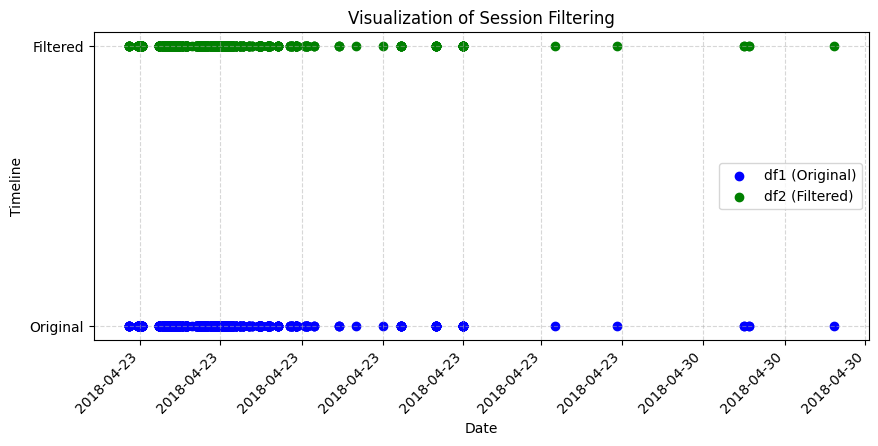

In [49]:
import random

pid = random.choice(pd.unique(sessions_filter_df["patient_id"]))
df1 = df[df.patient_id == pid]
df2 = sessions_filter_df[sessions_filter_df.patient_id == pid]

# Convert start_time to just the date (drop time details)
df1['date'] = df1['start_time'].dt.date
df2['date'] = df2['start_time'].dt.date

# Find missing dates
missing_dates = set(df1['date']) - set(df2['date'])

# Create the figure
fig, ax = plt.subplots(figsize=(10, 4))

# Plot all dates from df1
ax.scatter(df1['date'], [1] * len(df1), label='df1 (Original)', color='blue', marker='o')

# Plot retained dates from df2
ax.scatter(df2['date'], [2] * len(df2), label='df2 (Filtered)', color='green', marker='o')

# Highlight missing dates
for missing in missing_dates:
    ax.scatter(missing, 1, color='red', marker='x', label="Removed" if missing == list(missing_dates)[0] else "")

# Formatting
ax.set_yticks([1, 2])
ax.set_yticklabels(["Original", "Filtered"])
ax.set_xticklabels(df1['date'], rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Timeline")
plt.title("Visualization of Session Filtering")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()